# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import pickle

from tqdm.auto import tqdm

# Data Exploration, Preprocessing, & Feature Engineering

In [2]:
df = pd.read_csv('ai4i2020.csv')

df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(r"[\[\]<>]", "", regex=True)
drop_columns = ['udi', 'product_id', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
df = df.drop(columns=drop_columns)
df['type'] = df['type'].apply(lambda x: x.lower())

df.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure
0,m,298.1,308.6,1551,42.8,0,0
1,l,298.2,308.7,1408,46.3,3,0
2,l,298.1,308.5,1498,49.4,5,0
3,l,298.2,308.6,1433,39.5,7,0
4,l,298.2,308.7,1408,40.0,9,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   10000 non-null  object 
 1   air_temperature_k      10000 non-null  float64
 2   process_temperature_k  10000 non-null  float64
 3   rotational_speed_rpm   10000 non-null  int64  
 4   torque_nm              10000 non-null  float64
 5   tool_wear_min          10000 non-null  int64  
 6   machine_failure        10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


In [4]:
df['machine_failure'].value_counts()

machine_failure
0    9661
1     339
Name: count, dtype: int64

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, shuffle=True)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train['machine_failure'].values
y_train = df_train['machine_failure'].values
y_val = df_val['machine_failure'].values
y_test = df_test['machine_failure'].values

del df_train['machine_failure']
del df_val['machine_failure']
del df_test['machine_failure']


# Scaling the numerical features to implement Log. Regression
scaler = StandardScaler()
num_features = ['air_temperature_k', 'process_temperature_k',
                'rotational_speed_rpm', 'torque_nm', 
                'tool_wear_min']

df_full_train_scaled = df_full_train.copy()
df_full_train_scaled[num_features] = scaler.fit_transform(df_full_train_scaled[num_features])

df_train_scaled = df_train.copy()
df_train_scaled[num_features] = scaler.fit_transform(df_train_scaled[num_features])

df_val_scaled = df_val.copy()
df_val_scaled[num_features] = scaler.transform(df_val_scaled[num_features])

df_test_scaled = df_test.copy()
df_test_scaled[num_features] = scaler.transform(df_test_scaled[num_features])


# Encode Categorical Features
dv = DictVectorizer(sparse=False)

dicts_df_train = df_train.to_dict(orient='records')
X_train = dv.fit_transform(dicts_df_train)

dicts_df_val = df_val.to_dict(orient='records')
X_val = dv.transform(dicts_df_val)

dicts_df_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_df_test)

dicts_df_train_scaled = df_train_scaled.to_dict(orient='records')
X_train_scaled = dv.transform(dicts_df_train_scaled)

dicts_df_val_scaled = df_val_scaled.to_dict(orient='records')
X_val_scaled = dv.transform(dicts_df_val_scaled)

dicts_df_test_scaled = df_test_scaled.to_dict(orient='records')
X_test_scaled = dv.transform(dicts_df_test_scaled)

# Models Train & Validation

### Logistic Regression

In [6]:
# Tune model with multiple C value

Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
score = []

for C in Cs:
    lr_clf = LogisticRegression(C=C, random_state=1)
    lr_clf.fit(X_train_scaled, y_train)

    y_pred = lr_clf.predict_proba(X_val_scaled)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    score.append((C, round(auc, 5)))

score = pd.DataFrame(score, columns=['C', 'auc'])
score.sort_values(by='auc', ascending=False).head()

,C,auc
2,0.1,0.89753
3,1.0,0.89609
4,10.0,0.89559
5,100.0,0.89556
6,1000.0,0.89555


In [7]:
# Final Model

lr_clf = LogisticRegression(C=0.1, random_state=1)
lr_clf.fit(X_train_scaled, y_train)

y_pred = lr_clf.predict_proba(X_val_scaled)[:,1]
lr_clf_auc_score = roc_auc_score(y_val, y_pred)
lr_clf_auc_score

np.float64(0.8975257731958763)

### Decision Tree

In [8]:
score = []

for d in range(1, 11): # tune model with diff max_depth
    dt_clf = DecisionTreeClassifier(max_depth=d, random_state=1)
    dt_clf.fit(X_train, y_train)

    y_pred = dt_clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    score.append((d, round(auc, 5)))

score = pd.DataFrame(score, columns=['max_depth', 'auc'])
score.sort_values(by='auc', ascending=False).head()

,max_depth,auc
5,6,0.88975
8,9,0.87408
7,8,0.86554
6,7,0.86434
4,5,0.85356


In [9]:
score = []

for d in [6, 7, 8, 9]:
    for l in range(1, 21):
        dt_clf = DecisionTreeClassifier(max_depth=d,
                                        min_samples_leaf=l,
                                        random_state=1)
        dt_clf.fit(X_train, y_train)
    
        y_pred = dt_clf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        score.append((d, l, round(auc, 5)))

columns = ['max_depth', 'min_sample_leaf', 'auc']
score = pd.DataFrame(score, columns=columns)
score.sort_values(by='auc', ascending=False).head()

,max_depth,min_sample_leaf,auc
56,8,17,0.96064
57,8,18,0.96049
58,8,19,0.96049
55,8,16,0.96043
59,8,20,0.95903


In [10]:
# Final Model

dt_clf = DecisionTreeClassifier(max_depth=8,
                                min_samples_leaf=17,
                                random_state=1)
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict_proba(X_val)[:, 1]
dt_clf_auc_score = roc_auc_score(y_val, y_pred)
dt_clf_auc_score

np.float64(0.960640034364261)

### Random Forest

In [11]:
score = []

for e in tqdm(range(1, 201)):
    rf_clf = RandomForestClassifier(n_estimators=e, 
                                    random_state=1, 
                                    n_jobs=-1)
    rf_clf.fit(X_train, y_train)

    y_pred = rf_clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    score.append((e, auc))

score = pd.DataFrame(score, columns=['n_estimators', 'auc'])
score.sort_values(by='auc', ascending=False).head(10)

  0%|          | 0/200 [00:00<?, ?it/s]

,n_estimators,auc
194,195,0.970829
195,196,0.970790
196,197,0.970773
197,198,0.970713
193,194,0.970687
198,199,0.970679
199,200,0.970662
188,189,0.970584
189,190,0.970546
190,191,0.970503


Text(0.5, 1.0, 'auc score at each n_estimators')

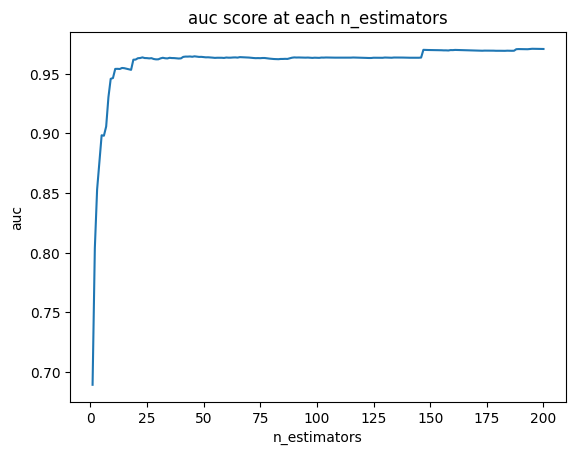

In [12]:
plt.plot(score['n_estimators'], score['auc'])
plt.xlabel('n_estimators')
plt.ylabel('auc')
plt.title('auc score at each n_estimators')

In [13]:
score = []

for d in tqdm(range(1, 21)):
    for e in [195, 196, 197, 198]:
        rf_clf = RandomForestClassifier(n_estimators=e,
                                        max_depth=d,
                                        random_state=1, 
                                        n_jobs=-1)
        rf_clf.fit(X_train, y_train)
    
        y_pred = rf_clf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        score.append((d, e, auc))

score = pd.DataFrame(score, columns=['max_depth', 'n_estimators', 'auc'])
score.sort_values(by='auc', ascending=False).head(10)

  0%|          | 0/20 [00:00<?, ?it/s]

,max_depth,n_estimators,auc
36,10,195,0.977715
37,10,196,0.977646
38,10,197,0.977646
39,10,198,0.977586
45,12,196,0.976692
47,12,198,0.976692
44,12,195,0.976684
46,12,197,0.976658
50,13,197,0.975799
49,13,196,0.975773


In [14]:
score = []

for s in tqdm(range(1, 21)):
    rf_clf = RandomForestClassifier(n_estimators=195,
                                    max_depth=10,
                                    min_samples_leaf=s,
                                    random_state=1, 
                                    n_jobs=-1)
    rf_clf.fit(X_train, y_train)

    y_pred = rf_clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    score.append((s, auc))

score = pd.DataFrame(score, columns=['min_sample_leaf', 'auc'])
score.sort_values(by='auc', ascending=False).head(10)

  0%|          | 0/20 [00:00<?, ?it/s]

,min_sample_leaf,auc
0,1,0.977715
1,2,0.977680
5,6,0.975395
7,8,0.974742
8,9,0.973617
2,3,0.973582
6,7,0.973368
3,4,0.972930
12,13,0.972079
9,10,0.972070


In [15]:
# final model

rf_clf = RandomForestClassifier(n_estimators=195,
                                max_depth=10,
                                min_samples_leaf=1,
                                random_state=1, 
                                n_jobs=-1)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict_proba(X_val)[:, 1]
rf_clf_auc_score = roc_auc_score(y_val, y_pred)
rf_clf_auc_score

np.float64(0.9777147766323024)

### XGBoost

In [16]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

result = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]
params = {
    'objective': 'binary:logistic',
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1
}

xgb_clf = xgb.train(
    params = params,
    dtrain = dtrain,
    num_boost_round = 300,
    evals = watchlist,
    evals_result = result,
    verbose_eval = 0
)


In [17]:
df_scores = pd.DataFrame()
df_scores['num_boost_round'] = [i+1 for i in range(300)]
df_scores['auc'] = result['val']['auc']
df_scores.sort_values(by='auc', ascending=False).head()

,num_boost_round,auc
26,27,0.982397
27,28,0.982268
25,26,0.982251
28,29,0.982242
29,30,0.981873


In [18]:
etas = [round(i, 1) for i in np.linspace(0.1, 1, 10)]
result = {}

for eta in tqdm(etas):
    eval_result = {}
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    params = {
        'objective': 'binary:logistic',
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'eval_metric': 'auc',
        'seed': 1,
        'verbosity': 1
    }
    
    xgb_clf = xgb.train(
        params = params,
        dtrain = dtrain,
        num_boost_round = 300,
        evals = watchlist,
        evals_result = eval_result,
        verbose_eval = 0
    )

    df_scores = pd.DataFrame()
    df_scores['num_boost_round'] = np.arange(1, 301)
    df_scores['auc'] = eval_result['val']['auc']
    

    result[f'eta={eta}'] = df_scores
        

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
for key in result:
    print(key)
    print(result[key].sort_values(by='auc', ascending=False).head(3))
    print()

eta=0.1
    num_boost_round       auc
39               40  0.984837
40               41  0.984712
41               42  0.984463

eta=0.2
    num_boost_round       auc
27               28  0.984811
28               29  0.984794
26               27  0.984785

eta=0.3
    num_boost_round       auc
26               27  0.982397
27               28  0.982268
25               26  0.982251

eta=0.4
    num_boost_round       auc
13               14  0.982547
14               15  0.982418
11               12  0.981980

eta=0.5
    num_boost_round       auc
10               11  0.980490
9                10  0.979472
8                 9  0.979420

eta=0.6
    num_boost_round       auc
9                10  0.981044
12               13  0.981022
13               14  0.980249

eta=0.7
   num_boost_round       auc
4                5  0.976873
7                8  0.975924
9               10  0.975481

eta=0.8
   num_boost_round       auc
7                8  0.979549
5                6  0.979377
8     

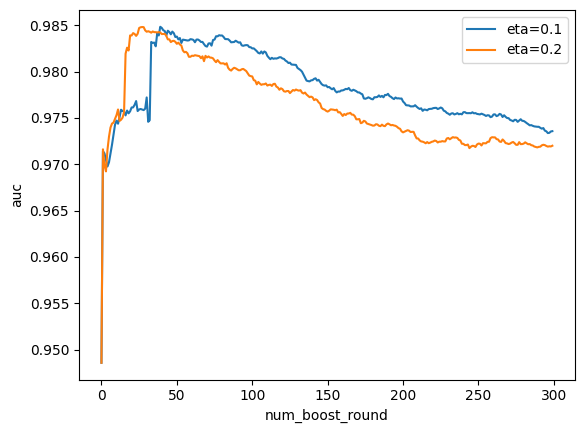

In [20]:
for key in ['eta=0.1', 'eta=0.2']:
    plt.plot(result[key]['auc'], label=f'{key}')
plt.xlabel('num_boost_round')
plt.ylabel('auc')
plt.legend()

In [21]:
eta = 0.1
result = {}

for d in tqdm(range(1, 11)):
    eval_result = {}
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    params = {
        'objective': 'binary:logistic',
        'eta': eta,
        'max_depth': d,
        'min_child_weight': 1,
        'eval_metric': 'auc',
        'seed': 1,
        'verbosity': 1
    }
    
    xgb_clf = xgb.train(
        params = params,
        dtrain = dtrain,
        num_boost_round = 300,
        evals = watchlist,
        evals_result = eval_result,
        verbose_eval = 0
    )

    df_scores = pd.DataFrame()
    df_scores['num_boost_round'] = np.arange(1, 301)
    df_scores['auc'] = eval_result['val']['auc']
    

    result[f'max_depth={d}'] = df_scores
        

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
for key in result:
    print(key)
    print(result[key].sort_values(by='auc', ascending=False).head(3))
    print()

max_depth=1
     num_boost_round       auc
135              136  0.945576
139              140  0.945541
157              158  0.945382

max_depth=2
     num_boost_round       auc
294              295  0.976838
299              300  0.976796
295              296  0.976778

max_depth=3
     num_boost_round       auc
273              274  0.976486
254              255  0.976460
267              268  0.976460

max_depth=4
     num_boost_round       auc
115              116  0.982912
172              173  0.982912
173              174  0.982878

max_depth=5
    num_boost_round       auc
58               59  0.983247
59               60  0.983084
53               54  0.983028

max_depth=6
    num_boost_round       auc
39               40  0.984837
40               41  0.984712
41               42  0.984463

max_depth=7
    num_boost_round       auc
41               42  0.985258
40               41  0.985215
38               39  0.985103

max_depth=8
    num_boost_round       auc
40         

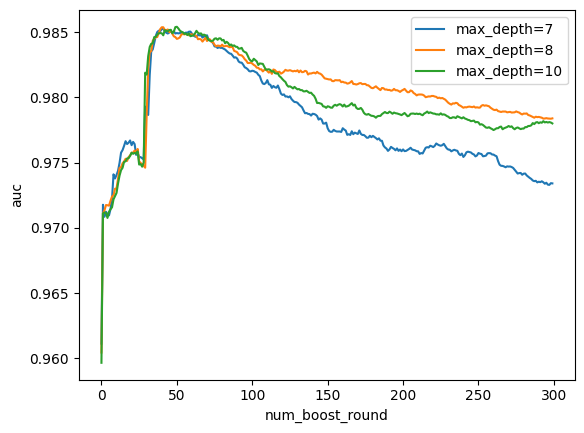

In [23]:
for key in ['max_depth=7', 'max_depth=8', 'max_depth=10']:
    plt.plot(result[key]['auc'], label=f'{key}')
plt.xlabel('num_boost_round')
plt.ylabel('auc')
plt.legend()

In [24]:
eta = 0.1
max_depth = 10
result = {}

for w in tqdm(range(1, 21)):
    eval_result = {}
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    params = {
        'objective': 'binary:logistic',
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': w,
        'eval_metric': 'auc',
        'seed': 1,
        'verbosity': 1
    }
    
    xgb_clf = xgb.train(
        params = params,
        dtrain = dtrain,
        num_boost_round = 300,
        evals = watchlist,
        evals_result = eval_result,
        verbose_eval = 0
    )

    df_scores = pd.DataFrame()
    df_scores['num_boost_round'] = np.arange(1, 301)
    df_scores['auc'] = eval_result['val']['auc']
    

    result[f'min_child_weight={w}'] = df_scores
        

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
for key in result:
    print(key)
    print(result[key].sort_values(by='auc', ascending=False).head(3))
    print()

min_child_weight=1
    num_boost_round       auc
50               51  0.985404
49               50  0.985378
51               52  0.985275

min_child_weight=2
    num_boost_round       auc
40               41  0.983956
38               39  0.983939
39               40  0.983845

min_child_weight=3
    num_boost_round       auc
38               39  0.984046
35               36  0.983883
39               40  0.983883

min_child_weight=4
    num_boost_round       auc
56               57  0.982036
57               58  0.981993
55               56  0.981950

min_child_weight=5
    num_boost_round       auc
44               45  0.983479
45               46  0.983325
51               52  0.983299

min_child_weight=6
    num_boost_round       auc
70               71  0.979351
71               72  0.979214
73               74  0.979119

min_child_weight=7
    num_boost_round       auc
60               61  0.980082
59               60  0.979944
61               62  0.979918

min_child_weight=8
 

In [26]:
# Final Model

eta = 0.1
max_depth = 10
min_child_weight = 1

params = {
    'objective': 'binary:logistic',
    'eta': eta,
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1
}

xgb_clf = xgb.train(
    params = params,
    dtrain = dtrain,
    num_boost_round = 51,
    #evals = watchlist,
    #evals_result = eval_result,
    verbose_eval = 0
)

y_pred = xgb_clf.predict(dval)
xgb_clf_auc_score = roc_auc_score(y_val, y_pred)
xgb_clf_auc_score

np.float64(0.9854037800687285)

# Model Selection

### AUC Score Summary

                 model       auc
3              XGBoost  0.985404
2        Random Forest  0.977715
1        Decision Tree  0.960640
0  Logistic Regression  0.897526


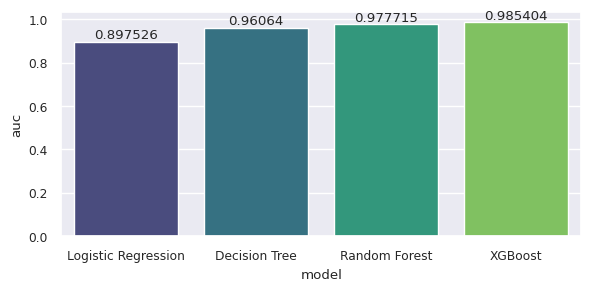

In [27]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
scores = [lr_clf_auc_score, dt_clf_auc_score, rf_clf_auc_score, xgb_clf_auc_score]

df_scores = pd.DataFrame(data={'model':models, 
                               'auc':scores})

print(df_scores.sort_values(by='auc', ascending=False))


plt.figure(figsize=(6, 3))
sns.set(font_scale=0.8)
ax = sns.barplot(x=df_scores['model'], y=df_scores['auc'], 
                 hue=df_scores['model'], palette='viridis')
for a in ax.containers:
    ax.bar_label(a)
plt.tight_layout()
plt.show()

The choosen model based on evaluation metric (ROC AUC Score) is XGBoost.

### Using Model

Experiment by training the full train dataset (the combined train and validation dataset) on the existing models (same parameters) and evaluating it using the test dataset to see if there are any changes or overfit indications.

In [28]:
# Encode full_train dataset

dicts_df_full_train = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(dicts_df_full_train)

dicts_df_full_train_scaled = df_full_train_scaled.to_dict(orient='records')
X_full_train_scaled = dv.transform(dicts_df_full_train_scaled)

In [29]:
# Logistic Regression

lr_clf.fit(X_full_train_scaled, y_full_train)
y_pred = lr_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.9283378813580155)

In [30]:
# Decision Tree

dt_clf.fit(X_full_train, y_full_train)
y_pred = dt_clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.968471126189247)

In [31]:
# Random Forest

rf_clf.fit(X_full_train, y_full_train)
y_pred = rf_clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.9733182551974499)

In [32]:
# XGBoost

dfulltrain = xgb.DMatrix(X_full_train,
                         label=y_full_train, 
                         feature_names=features)
dtest = xgb.DMatrix(X_test, feature_names=features)

eta = 0.1
max_depth = 10
min_child_weight = 1

params = {
    'objective': 'binary:logistic',
    'eta': eta,
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1
}

xgb_clf = xgb.train(
    params = params,
    dtrain = dfulltrain,
    num_boost_round = 51,
    #evals = watchlist,
    #evals_result = eval_result,
    verbose_eval = 0
)

y_pred = xgb_clf.predict(dtest)
roc_auc_score(y_test, y_pred)

np.float64(0.9775139103998165)

### Save The Model and The Encoder Using Pickle Library

In [33]:

with open('xgb_clf.bin', 'wb') as f:
    pickle.dump((xgb_clf, dv), f)


### Trying the scikit-learn-like way to train the XGBoost model 

In [34]:
# Parameters
eta = 0.1
max_depth = 10
min_child_weight = 1

# Initialize XGBClassifier
xgb_clf_ = XGBClassifier(
    objective='binary:logistic',
    learning_rate=eta,
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    n_estimators=51,
    eval_metric='auc',
    random_state=1,
    verbosity=1
)

# Train the model
xgb_clf_.fit(
    X_full_train, y_full_train,
    eval_set=[(X_test, y_test)], 
    verbose=0                     
)

# Make predictions
y_pred = xgb_clf_.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

ROC AUC Score: 0.9775139103998165


### Simulate The Model (Failure Detection) Using A Sample of Observation

In [35]:
sample = {
    'type': 'l',
    'air_temperature_k': 300.5,
    'process_temperature_k': 309.6,
    'rotational_speed_rpm': 1390,
    'torque_nm': 48.4,
    'tool_wear_min': 194,
    'machine_failure': 0
}

In [36]:
X = dv.transform([sample])
dX = xgb.DMatrix(X, feature_names=features)
xgb_clf.predict(dX)

array([0.00311739], dtype=float32)